In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
import ee
import datetime
import tqdm

import pandas as pd
import geopandas as gp
import numpy as np
import rsfuncs as rs

import matplotlib.pyplot as plt

from tqdm import tqdm

ee.Initialize()

In [2]:
gdf = gp.read_file("../shape/cv.shp")
data = rs.load_data()
data['dmet'] = [ee.ImageCollection('NASA/ORNL/DAYMET_V4'), "prcp", 1, 1000]
area = rs.gdf_to_ee_poly(gdf.simplify(0.1))


<AxesSubplot:>

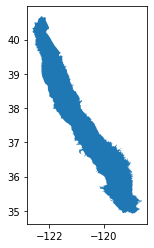

In [3]:
gdf.plot()

In [4]:
def dict2arr(data_dict, var_name):
    '''converts ee dictionary output from .getInfo() to a numpy array. Wraps array_from_df'''
    
    data = data_dict[var_name]
    lats = data_dict['latitude']
    lons = data_dict['longitude']

    df = pd.DataFrame([data,lats,lons]).T
    df.columns = [var_name, "latitude", 'longitude']
    arr = rs.array_from_df(df, var_name)
    
    return arr

def get_monthly_ims(dataset, start, end, aoi):
    '''
    Get gridded monthly data from EE
    '''

    ImageCollection = dataset[0]
    var = dataset[1]
    scaling_factor = dataset[2]
    resolution = dataset[3]

    dt_idx = pd.date_range(start,end, freq='MS')
    ims = []
    seq = ee.List.sequence(0, len(dt_idx)-1)
    num_steps = seq.getInfo()
    
    for i in tqdm(num_steps[:]):

        t1 = ee.Date(start).advance(i, 'month')
        t2 = t1.advance(1, 'month');

        im = ee.Image(ImageCollection.select(var).filterDate(t1, t2).sum().set('system:time_start', t1.millis()))
        modis_dat = im.pixelLonLat().addBands(im).multiply(scaling_factor).reduceRegion(reducer=ee.Reducer.toList(),
                                                               geometry=aoi,
                                                               scale=resolution, crs ='EPSG:4326')

        modis_dict = modis_dat.getInfo()
        modis_im = dict2arr(modis_dict, var)
        ims.append(modis_im)

    return ims

In [5]:
ims = get_monthly_ims(data['dmet'], start = '2017-01-01', end = '2018-01-01', aoi = area)

100%|██████████| 13/13 [00:56<00:00,  4.35s/it]


<ipython-input-6-eb3cc46f89bb>:1: RuntimeWarning: Mean of empty slice
  plt.imshow(np.nanmean(ims, axis = 0))


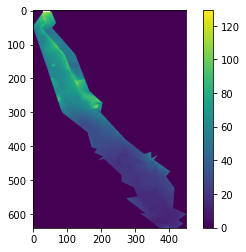

In [6]:
plt.imshow(np.nanmean(ims, axis = 0))
plt.colorbar()

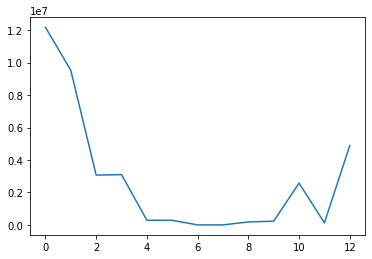

In [7]:
sums = [np.nansum(x) for x in ims]
plt.plot(sums)

In [8]:
# Get gpm data for 2000 - 2020

In [ ]:
gpm_ims = get_monthly_ims(data['gpm'], start = '2001-01-01', end = '2020-05-01', aoi = area)

  6%|▌         | 14/233 [00:04<01:08,  3.19it/s]

In [ ]:
plt.imshow(np.nanmean(gpm_ims, axis = 0))
plt.colorbar()

In [ ]:
gpm_sums = [np.nansum(x) for x in gpm_ims]
plt.plot(gpm_sums)

In [ ]:
gpm_arr = np.dstack(gpm_ims)
gpm_arr.shape

In [ ]:
np.save('../data/gpm.npy',gpm_arr)

In [32]:
def get_monthly_df(dataset, start, end, aoi):
    '''
    Get gridded monthly data from EE
    '''

    ImageCollection = dataset[0]
    var = dataset[1]
    scaling_factor = dataset[2]
    resolution = dataset[3]

    dt_idx = pd.date_range(start,end, freq='MS')
    df_rows = []
    seq = ee.List.sequence(0, len(dt_idx)-1)
    num_steps = seq.getInfo()
    
    for i in tqdm(num_steps[:]):

        t1 = ee.Date(start).advance(i, 'month')
        t2 = t1.advance(1, 'month');

        im = ee.Image(ImageCollection.select(var).filterDate(t1, t2).sum().set('system:time_start', t1.millis()))
        dat = im.pixelLonLat().addBands(im).multiply(scaling_factor).reduceRegion(reducer=ee.Reducer.toList(),
                                                               geometry=aoi,
                                                               scale=resolution, crs ='EPSG:4326')

        data_dict = dat.getInfo()
        data = data_dict[var]
        lats = data_dict['latitude']
        lons = data_dict['longitude']

        df = pd.DataFrame([data,lats,lons]).T
        df.columns = [var, "latitude", 'longitude']
        ee_dt = t1.format('yyyy,MM,dd,HH,mm,ss').getInfo()
        dt_args = ee_dt.split(',')
        intargs = [int(arg) for arg in dt_args]
        date =  datetime.datetime(*intargs)
        df['date']= date
        df_rows.append(df)

    return pd.concat(df_rows)

In [67]:
gpm_df = get_monthly_df(data['gpm'], start = '2001-01-01', end = '2020-05-01', aoi = area)

100%|██████████| 233/233 [01:17<00:00,  3.01it/s]


In [68]:
gpm_df.to_csv("../data/gpm.csv")

In [69]:
gpm_df.set_index('date', inplace = True)